In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
from pathlib import Path

print(os.getcwd())
sys.path.append(str(Path('../src').resolve()))

/media/dicarlod/SSD_2/diego/Code/INCANT/python/notebooks


In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import scipy.interpolate as interpolate
from matplotlib.colors import LogNorm

from tqdm import tqdm

from implicits import SIREN, MFN, continuous_diff

Data t0: (24253, 4)
Data t1: (26658, 4)
min [  6.375 216.5   248.309   0.   ]
mean [ 36.41119797 238.84924672 261.26950427   0.52361965]
max [ 64.5   261.5   275.804   1.   ]


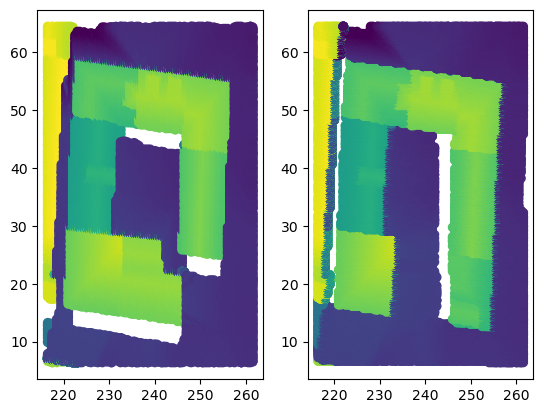

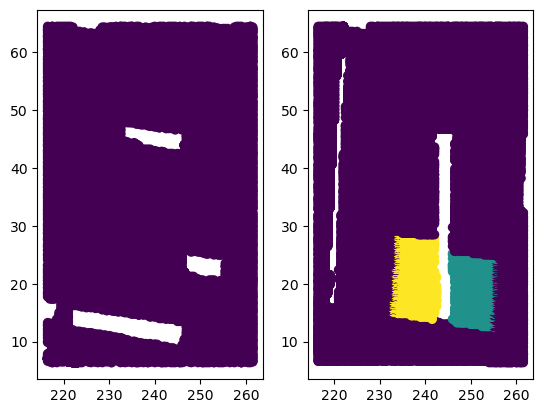

In [15]:
# Load Data
path_to_csv0 = Path("../../data/clippeddata/clippedMarco0.txt")
path_to_csv1 = Path("../../data/clippeddata/clippedMarco1.txt")


data_t0 = pd.read_csv(path_to_csv0).to_numpy()[:,:3]
label_t0 = pd.read_csv(path_to_csv0).to_numpy()[:,-1]
data_t0 = np.concatenate([data_t0, np.zeros((data_t0.shape[0],1))], axis=-1)
print('Data t0:', data_t0.shape)
data_t1 = pd.read_csv(path_to_csv1).to_numpy()[:,:3]
label_t1 = pd.read_csv(path_to_csv1).to_numpy()[:,-1]
data_t1 = np.concatenate([data_t1, np.ones((data_t1.shape[0],1))], axis=-1)
print('Data t1:', data_t1.shape)

data_t01 = np.concatenate([data_t0, data_t1], axis=0)
col_names = ["x","y","z","t"]

print("min", np.min(data_t01, axis=0))
print("mean", np.mean(data_t01, axis=0))
print("max", np.max(data_t01, axis=0))

n_points_per_dim = np.sqrt(max(data_t1.shape[0], data_t0.shape[0]))
n_points = int(np.ceil(n_points_per_dim))


plt.subplot(121)
plt.scatter(data_t0[...,1], 
            data_t0[...,0], 
            c=data_t0[...,2])
plt.subplot(122)
plt.scatter(data_t1[...,1], 
            data_t1[...,0], 
            c=data_t1[...,2])
plt.show()

plt.subplot(121)
plt.scatter(data_t0[...,1], 
            data_t0[...,0], 
            c=label_t0)
plt.subplot(122)
plt.scatter(data_t1[...,1], 
            data_t1[...,0], 
            c=label_t1)
plt.show()


(164, 164)
(164, 164)


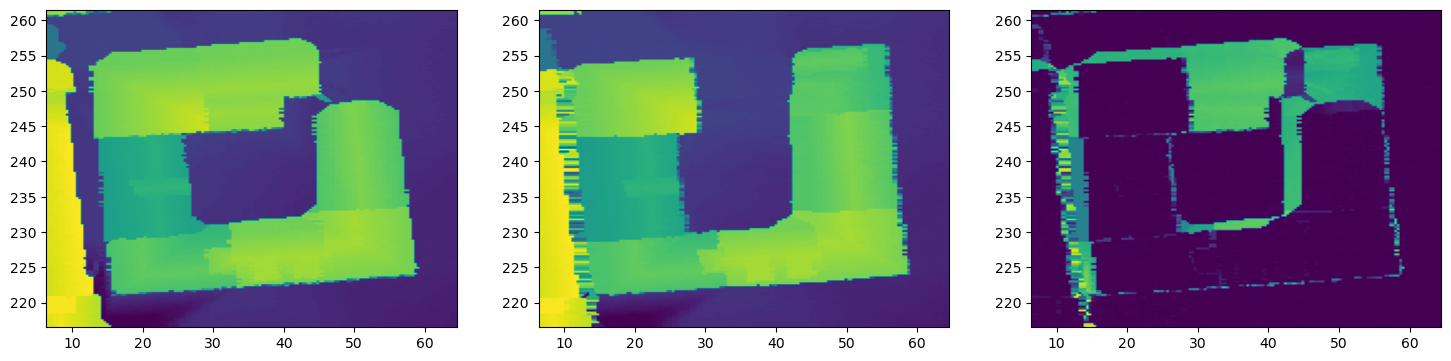

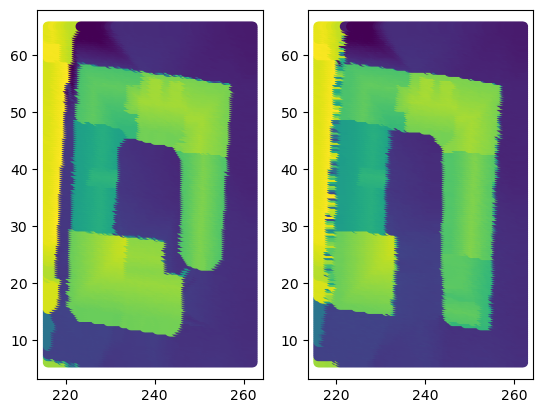

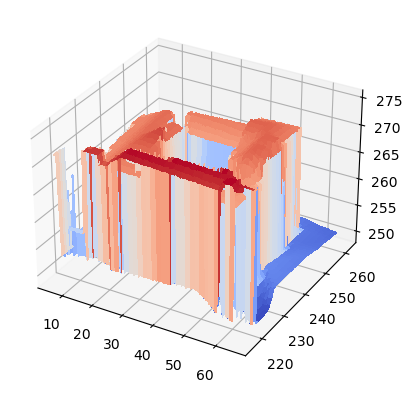

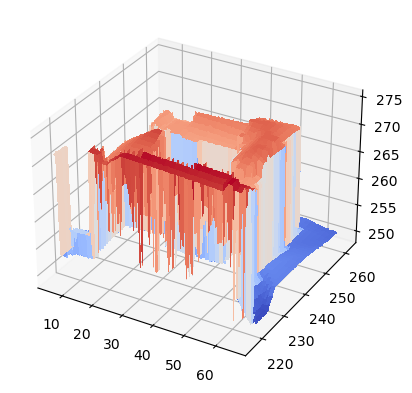

In [9]:
int_coord = []
int_target = []

for i, data in enumerate([data_t0, data_t1]):
    # interpolation
    xmax = np.max(data[:,:2], axis=0)
    xmin = np.min(data[:,:2], axis=0)

    # sort data by first column (xcoord)
    data_sorted = data.copy()
    data_sorted[data_sorted[:, 0].argsort()]

    xy = np.stack(np.meshgrid(
        np.linspace(np.floor(xmin[0]), np.ceil(xmax[0]), n_points),
        np.linspace(np.floor(xmin[1]), np.ceil(xmax[1]), n_points),
        indexing='ij'
    ), axis=-1)

    interp = interpolate.NearestNDInterpolator(data[:,:2], data[:,2])
    z = interp(xy)
    print(z.shape)

    int_coord.append(xy)
    int_target.append(z)


plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(int_target[0], extent=[xmin[0], xmax[0], xmin[1], xmax[1]])
plt.subplot(132)
plt.imshow(int_target[1], extent=[xmin[0], xmax[0], xmin[1], xmax[1]])
plt.subplot(133)
plt.imshow(np.abs(int_target[0] - int_target[1]), extent=[xmin[0], xmax[0], xmin[1], xmax[1]])
plt.show()

# Plot the surface.
for i in range(2):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(int_coord[i][...,0], int_coord[i][...,1], int_target[i], cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
    plt.show()

In [16]:
from dsp_utils import powerspec

(164, 164)
(164, 164)


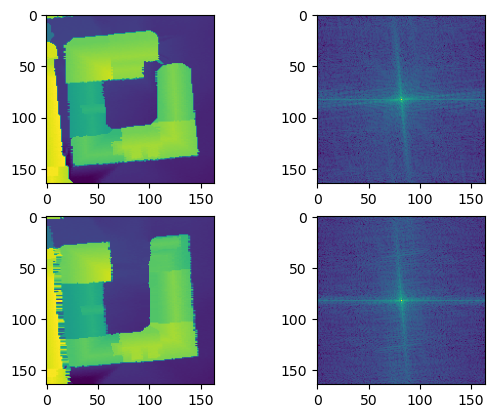

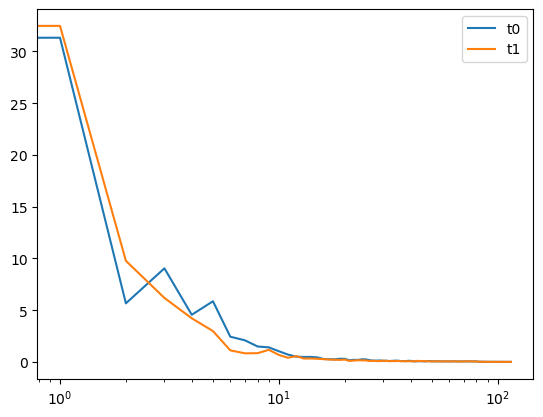

In [17]:
# spatial resolution of the data
nfft = n_points
z0 = int_target[0]
Z0 = np.fft.fftshift(np.fft.fft2(z0, s=[nfft,nfft]))
print(Z0.shape)

z1 = int_target[1]
Z1 = np.fft.fftshift(np.fft.fft2(z1, s=[nfft,nfft]))
print(Z1.shape)

plt.subplot(221)
plt.imshow(z0)
plt.subplot(222)
plt.imshow(np.abs(Z0), norm=LogNorm(vmin=10))
plt.subplot(223)
plt.imshow(z1)
plt.subplot(224)
plt.imshow(np.abs(Z1), norm=LogNorm(vmin=10))
plt.show()

Ek0 = powerspec(z0, nfft=nfft)
Ek1 = powerspec(z1, nfft=nfft)
plt.semilogx(Ek0[1:], label='t0')
plt.semilogx(Ek1[1:], label='t1')
plt.legend()
plt.show()

## Graph Signal Processing

In [215]:
# from scipy.spatial import Delaunay
# import networkx as nx

In [216]:
# print(data.shape)
# pts = data[::8,:3]
# print(pts.shape)
# tess = Delaunay(pts, incremental=True)
# simplices = tess.simplices
# print(simplices.shape)

# # post processing
# # Separating small and large edges:
# thresh = 3.0  # user defined threshold in meters
# small_edges = set()
# large_edges = set()
# for tr in tess.vertices:
#     for i in range(3):
#         edge_idx0 = tr[i]
#         edge_idx1 = tr[(i+1)%3]
#         if (edge_idx1, edge_idx0) in small_edges:
#             continue  # already visited this edge from other side
#         if (edge_idx1, edge_idx0) in large_edges:
#             continue
#         p0 = pts[edge_idx0]
#         p1 = pts[edge_idx1]
#         if np.linalg.norm(p1 - p0) <  thresh:
#             small_edges.add((edge_idx0, edge_idx1))
#         else:
#             large_edges.add((edge_idx0, edge_idx1))

# simplices = small_edges

# # Convert it in to graph for further processing
# G = nx.Graph()
# for path in simplices:
#     nx.add_path(G, path)

# # lap = nx.laplacian_matrix(G).toarray()

In [217]:
# # Extract node and edge positions from the layout
# node_xyz = np.array([pts[v] for v in sorted(G)])
# edge_xyz = np.array([(pts[u], pts[v]) for u, v in G.edges()])

# # Create the 3D figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")

# # Plot the nodes - alpha is scaled by "depth" automatically
# ax.scatter(*node_xyz.T, s=2, ec="w")

# # Plot the edges
# for vizedge in edge_xyz:
#     ax.plot(*vizedge.T, color="tab:gray", alpha=0.5)


# def _format_axes(ax):
#     """Visualization options for the 3D axes."""
#     # Turn gridlines off
#     ax.grid(False)
#     # Suppress tick labels
#     for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
#         dim.set_ticks([])
#     # Set axes labels
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_zlabel("z")


# _format_axes(ax)
# fig.tight_layout()
# plt.show()


In [218]:
# lap = nx.laplacian_matrix(G).toarray()
# plt.imshow(lap)

In [219]:
import open3d as o3d

In [224]:
data = data_t0
pts = data[::8,:3]
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)

path_to_ply_data = str(Path("../../data/point_cloud.ply"))
# o3d.io.write_point_cloud(path_to_ply_data, pcd)

# Load saved point cloud and visualize it
# pcd = o3d.io.read_point_cloud(path_to_ply_data)

# downpcd = pcd.voxel_down_sample(voxel_size=0.05)
downpcd = pcd
o3d.visualization.draw_geometries([downpcd])

## heuristics

(3032, 3)
(3032,)


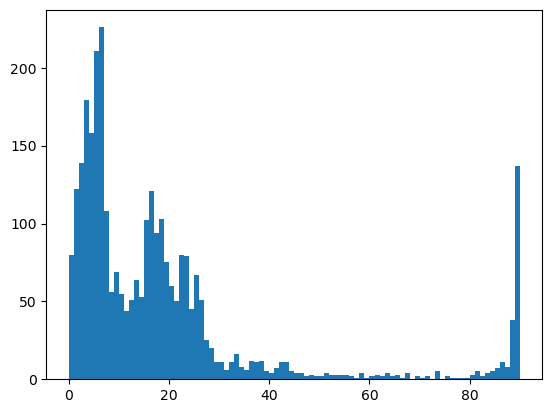

[75.82761236 88.42960307 28.13842746 ...  7.67984876  7.93243549
  7.89112548]
(234,)


In [227]:
## prune points with horizontal norms
radius =  3. # metres
downpcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=30))
dist, az, el = [1000, 0, 80]
campera_loc_car = np.array([
    dist*np.cos(np.deg2rad(el))*np.cos(np.deg2rad(az)),
    dist*np.cos(np.deg2rad(el))*np.sin(np.deg2rad(az)),
    dist*np.sin(np.deg2rad(el))
])
downpcd.orient_normals_towards_camera_location(
    camera_location=campera_loc_car)
o3d.visualization.draw_geometries([downpcd], point_show_normal=True)


normals = np.asarray(downpcd.normals)
print(normals.shape)
hpnorm = np.array([0,0,1])

angles = np.arccos(np.abs(normals @ hpnorm) / (
    np.linalg.norm(normals, axis=1) * np.linalg.norm(hpnorm) ))

print(angles.shape)

plt.hist(np.rad2deg(angles), bins=90)
plt.show()

print(np.rad2deg(angles))
ind = np.where(np.abs(np.rad2deg(angles)) > 70)[0]
print(ind.shape)

point_with_hnorm = downpcd.select_by_index(ind)
no_hnorm_pcd = downpcd.select_by_index(ind, invert=True)
to_plot = no_hnorm_pcd
o3d.visualization.draw_geometries([to_plot], point_show_normal=True)


In [229]:

## prune isolated points
radius = 1 # meter
nb_points = 1
cl, ind = no_hnorm_pcd.remove_radius_outlier(nb_points=nb_points, radius=radius)
non_sparse_pcd = no_hnorm_pcd.select_by_index(ind)
# outlier_cloud = downpcd.select_by_index(ind, invert=True)
o3d.visualization.draw_geometries([non_sparse_pcd], point_show_normal=True)

### Prune Vertical points

In [ ]:
# Create dataloader
class MarcoDataset(torch.utils.data.Dataset):
    def __init__(self, data, col_names, device):
        self.col_names = col_names
        self.data = data
        n_obs = self.data.shape[0]
        
        self.coords = torch.Tensor(self.data[:,[0,1,3]]).to(device)
        self.target = torch.Tensor(self.data[:,2][:,None]).to(device)
        
        # normalization between [-1,1] for SIREN
        self.coords = self.coords / torch.abs(torch.max(self.coords, axis=0, keepdim=True)[0])
        for d in range(self.coords.shape[1]):
            assert torch.max(self.coords[:,d][0]) <  1
            assert torch.max(self.coords[:,d][0]) > -1
        
        print(self.coords.shape)
        print(self.target.shape)
        
        
    def __len__(self):
        return self.coords.shape[0]
    
    def __getitem__(self, idx):
        coords = self.coords[idx,:]
        target = self.target[idx,:]
        return (coords, target)